## Fast and Accurate EMRI Waveforms Tutorial

Here we provide a set of examples for creating EMRI waveforms as a whole; looking at separate creation pieces (trajectory, amplitude, summation, etc.); and creating your own module to build directly into this framework. For details on the specifics of our waveforms like constructions used and generally methodology, we refer you to our papers [arxiv.org/2104.04582](https://arxiv.org/abs/2104.04582) and [arxiv.org/2008.06071](https://arxiv.org/abs/2008.06071) and the [package documentation](https://bhptoolkit.org/FastEMRIWaveforms/). 

In [17]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap, 
                               get_mismatch, 
                               get_fundamental_frequencies, 
                               get_separatrix, 
                               get_mu_at_t, 
                               get_p_at_t, 
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase

## Full EMRI Waveforms in Schwarzschild Eccentric

In the section, we will describe how to create EMRI waveforms with both our fast and slow EMRI waveform model. The current full models include [FastSchwarzschildEccentricFlux](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.FastSchwarzschildEccentricFlux) and [SlowSchwarzschildEccentricFlux](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.SlowSchwarzschildEccentricFlux). These are fast and slow versions of models that evolve eccentric flux-based trajectories in a Schwarzschild background. The fast model can be run exactly as shown here on CPUs or GPUs by providing the correct initialization arguments. 

The waveform model produces $h(t) = h_p - ih_c(t)$. It takes as arguments $\{M, \mu, p_0, e_0, \Phi_{\phi,0}, \Phi_{r, 0}\}$. $M$ is the larger mass ($M_\odot$), $\mu$ is the compact object mass ($M_\odot$), $p_0$ is the initial semi-latus rectum (dimensionless), $e_0$ is the initial eccentricity, and the final two are the initial phases in $\phi, r$.

### [FastSchwarzschildEccentricFlux](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.FastSchwarzschildEccentricFlux)

The fast waveform generates sparse trajectories with ~100 points. Amplitudes for all modes are then determined with ROMAN network. From these amplitudes, we perform mode selection to remove modes that do not contribute significantly to the waveform. The remaining modes and phases are then interpolated with cubic splines. In one final step, the amplitude, phase, and angular harmonic information is then combined with an interpolated summation. 

* Trajectory Module: [RunSchwarzEccFluxInspiral](https://bhptoolkit.org/FastEMRIWaveforms/html/user/traj.html#few.trajectory.flux.RunSchwarzEccFluxInspiral)

* Amplitude Module: [RomanAmplitude](https://bhptoolkit.org/FastEMRIWaveforms/html/user/amp.html#few.amplitude.romannet.RomanAmplitude)

* Summation Module: [InterpolateModeSum](https://bhptoolkit.org/FastEMRIWaveforms/html/user/sum.html#few.summation.interpolatedmodesum.CubicSplineInterpolant)

* Mode Selection: [ModeSelector](https://bhptoolkit.org/FastEMRIWaveforms/html/user/util.html#few.utils.modeselector.ModeSelector)

* Angular Harmonics: [GetYlms](https://bhptoolkit.org/FastEMRIWaveforms/html/user/util.html#few.utils.ylm.GetYlms)


In [18]:
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

# set omp threads one of two ways
num_threads = 4

# this is the general way to set it for all computations
from few.utils.utility import omp_set_num_threads
omp_set_num_threads(num_threads)

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
    num_threads=num_threads,  # 2nd way for specific classes
)

In [3]:
# parameters
M = 1e6
mu = 1e2
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle
dt = 10.0

wave = few(M, mu, p0, e0, theta, phi, dt=dt, T=1.0)  #  assumes dt = 10.0 for max T = 1.0 year

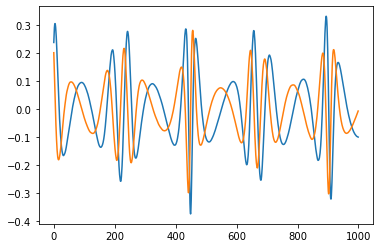

In [4]:
dt = 10.0
t = np.arange(len(wave)) * dt

plt.plot(wave.real[:1000])
plt.plot(wave.imag[:1000])

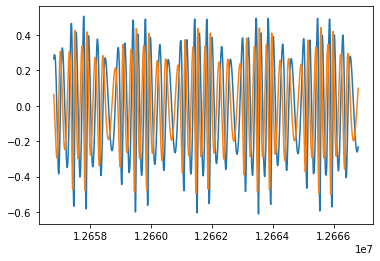

In [5]:
plt.plot(t[-1000:], wave.real[-1000:])
plt.plot(t[-1000:], wave.imag[-1000:])

To get shorter waveforms, you can provide the `T` kwarg for the function call. This is the observation time in years. You can also adjust `dt`. This is the time change in samples in seconds.

85300.0

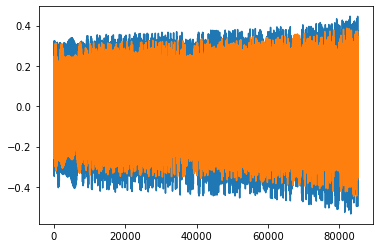

In [6]:
# parameters
M = 1e5
mu = 1e1
p0 = 8.0
e0 = 0.1
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle

dt = 10.0 # seconds
T = 0.1  # years
wave = few(M, mu, p0, e0, theta, phi, T=T, dt=dt)

# we can check how many harmonic modes are kept

t = np.arange(len(wave))*dt
plt.plot(t, wave.real)
plt.plot(t, wave.imag)

dt*(len(wave) - 1)

The `eps` kwarg will change the mode content of the waveform. Lowering it add modes. Increasing it will remove modes. The default is $10^{-5}$. This is generally recommended as good setting for good overlaps across the available parameter space.

wave1 used 454 modes. wave2 used 25 modes. The mismatch was 0.001212262901235106


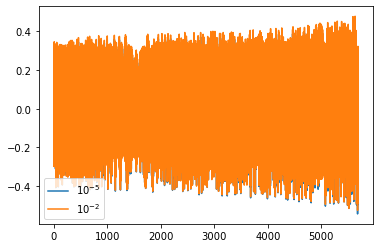

In [7]:
dt = 15.0 # seconds
T = 0.005  # years
wave1 = few(M, mu, p0, e0, theta, phi, T=T, dt=dt, eps=1e-5)  # default

# we can check how many harmonic modes are kept
modes1 = few.num_modes_kept

wave2 = few(M, mu, p0, e0, theta, phi, T=T, dt=dt, eps=1e-2)

modes2 = few.num_modes_kept

plt.plot(wave1.real, label=r'$10^{-5}$')
plt.plot(wave2.real, label=r'$10^{-2}$')
plt.legend()

# we can also compute the mismatch when removing modes
mm = get_mismatch(wave1, wave2)

# we can check how many modes were kept
print('wave1 used {} modes. wave2 used {} modes. The mismatch was {}'.format(modes1, modes2, mm))

### Waveform scaled by distance (generated in source frame)

The FastSchwarzschildEccentricFlux waveform is generated with source frame viewing angles. For all previous examples, the `dist` kwarg was left blank. To scale the waveform by the distance, you can add the distance in Gpc as a kwarg in the waveform generation class.

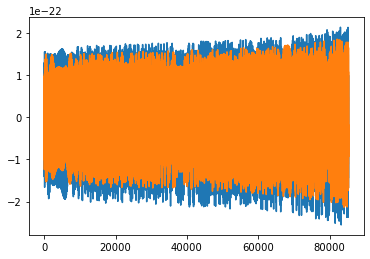

In [8]:
# parameters
M = 1e5
mu = 1e1
p0 = 8.0
e0 = 0.1
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle
dist = 1.0  # distance in Gpc

dt = 10.0 # seconds
T = 0.1  # years
wave = few(M, mu, p0, e0, theta, phi, dist=dist, T=T, dt=dt)

# we can check how many harmonic modes are kept

t = np.arange(len(wave))*dt
plt.plot(t, wave.real)
plt.plot(t, wave.imag)

### Producing waveforms with the generic interface

Waveforms can also be generated through a generic interface ([GenerateEMRIWaveform](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.GenerateEMRIWaveform)) where the specific waveform model is chosen with an argument. This can also be used to produce waveforms in the detector frame used for data analysis. This interface includes all EMRI parameters, including spin and inclination, as well as sky and orientation parameters. When a specific waveform model does not require certain parameters, the parameters will not affect the waveform generation. A detector-frame waveform in this case means $h_+,h_x$ in the SSB-frame. 

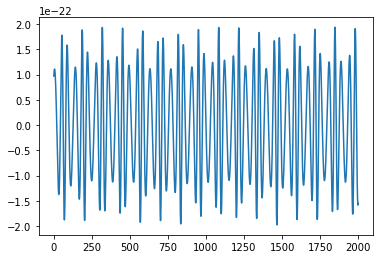

In [9]:
gen_wave = GenerateEMRIWaveform("FastSchwarzschildEccentricFlux")

# parameters
T = 0.01  # years
dt = 15.0  # seconds
M = 1e6
a = 0.1  # will be ignored in Schwarzschild waveform
mu = 1e1
p0 = 12.0
e0 = 0.2
x0 = 1.0  # will be ignored in Schwarzschild waveform
qK = 0.2  # polar spin angle
phiK = 0.2  # azimuthal viewing angle
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal viewing angle
dist = 1.0  # distance
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0

h = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

plt.plot(h.real[:2000])

### [SlowSchwarzschildEccentricFlux](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.SlowSchwarzschildEccentricFlux)

The slow waveform generates dense trajectories with at every `dt` seconds within `T` years. Amplitudes for all modes are then determined with a 2d bicubic spline over semi-latus rectum and eccentricity for each mode. This is done at each dense time step. We do not perform mode selection because this is the slow and most accurate model against which we compare the fast model. The final summation is a direct combination of phase, amplitude, and Ylm information at each dense timestep. 

**Note**: One thing to pay attention to with the slow waveform is batch size. This is determined by memory limits. Usually anything under ~10000 is fine.

* Trajectory Module: [RunSchwarzEccFluxInspiral](https://bhptoolkit.org/FastEMRIWaveforms/html/user/traj.html#few.trajectory.flux.RunSchwarzEccFluxInspiral)

* Amplitude Module: [Interp2DAmplitude](https://bhptoolkit.org/FastEMRIWaveforms/html/user/amp.html#few.amplitude.interp2dcubicspline.Interp2DAmplitude)

* Summation Module: [DirectModeSum](https://bhptoolkit.org/FastEMRIWaveforms/html/user/sum.html#few.summation.directmodesum.DirectModeSum)

* Mode Selection: None

* Angular Harmonics: [GetYlms](https://bhptoolkit.org/FastEMRIWaveforms/html/user/util.html#few.utils.ylm.GetYlms)


In [10]:
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 1,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e7),  # dense stepping trajectories
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e4),  # this must be >= batch_size
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu  # GPU is available for this type of summation
}

slow = SlowSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

# parameters
T = 0.005  # years
dt = 15.0 # seconds
M = 1e6
mu = 1e1
p0 = 8.0
e0 = 0.2
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle
dist = 1.0  # distance in Gpc
batch_size = int(1e4)

slow_wave = slow(M, mu, p0, e0, theta, phi, dist=dist, T=T, dt=dt, batch_size=batch_size, mode_selection='all')

Length check: 10520 10520
Mismatch: 2.3090905884814994e-05


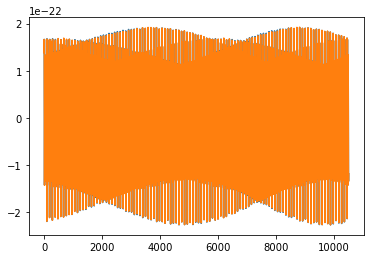

In [11]:
fast_wave = few(M, mu, p0, e0, theta, phi, dist=dist, T=T, dt=dt)

plt.plot(slow_wave.real)
plt.plot(fast_wave.real)
print('Length check:', len(fast_wave), len(slow_wave))
print('Mismatch:', get_mismatch(slow_wave, fast_wave))

## Trajectory Module

The trajectory module generates orbital and phase trajectories, $G(t)$, for an EMRI orbit:  

\begin{equation}
G(t) = \{p(t), e(t), \iota(t), \Phi_\phi(t), \Phi_\theta(t), \Phi_r(t)\}
\end{equation}

with inputs $M, \mu, p_0, e_0, \iota_0, \Phi_{\phi,0}, \Phi_{\theta,0}, \Phi_{r, 0}$. $M$ is the larger mass ($M_\odot$), $\mu$ is the compact object mass ($M_\odot$), $p_0$ is the initial semi-latus rectum (dimensionless), $e_0$ is the initial eccentricity, and the final three are the initial phases in $\phi, \theta, r$. When working in equatorial orbits, $\iota(t)$ and $\Phi_\theta(t)$ are zero. The trajectory module also produces the gravitational wave flux for normalization information.

### Run a basic trajectory

In [19]:
# initialize trajectory class
traj = EMRIInspiral(func="CircEq")

In [16]:
# set initial parameters
M = 1e5
mu = 1e1
p0 = 10.0
a = 0.7

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, 0.7, 1.0)

SystemError: <pyInspiral.pyInspiralGenerator object at 0x7fc9af3eab50> returned a result with an error set

In [ ]:
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$', r'Flux']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e, p, e, Phi_phi, Phi_r]
xs = [p, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

### Defining a new t vector

/Users/michaelkatz/anaconda3/envs/few_env/lib/python3.7/site-packages/few-1.3.7-py3.7-macosx-10.9-x86_64.egg/few/utils/baseclasses.py:740: UserWarning: new_t array goes beyond generated t array. If you want to cut the t array at the end of the trajectory, set fix_t to True.
  "new_t array goes beyond generated t array. If you want to cut the t array at the end of the trajectory, set fix_t to True."


t1 max: 999999.0 t2 max: 464363.0


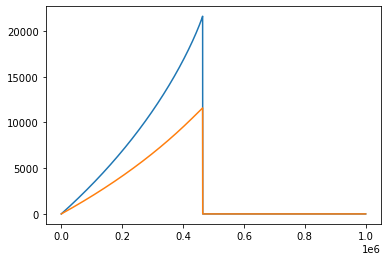

In [15]:
new_t = np.arange(0, 1e6, 1.0) 

# set initial parameters
M = 1e5
mu = 1e1
p0 = 10.0
e0 = 0.7

# a warning will be thrown if the new_t array goes beyond the time array output from the trajectory
t1, p1, e1, x1, Phi_phi1, Phi_theta1, Phi_r1 = traj(M, mu, 0.0, p0, e0, 1.0, new_t=new_t, upsample=True)

# you can cut the excess on these arrays by setting fix_t to True
t2, p2, e2, x2, Phi_phi2, Phi_theta2, Phi_r2 = traj(M, mu, 0.0, p0, e0, 1.0, new_t=new_t, upsample=True, fix_t=True)

plt.plot(t1, Phi_phi1, label=r'$\Phi_\phi$')
plt.plot(t1, Phi_r1, label=r'$\Phi_r$')

print('t1 max:', t1.max(), 't2 max:', t2.max())


### Defining dt and T

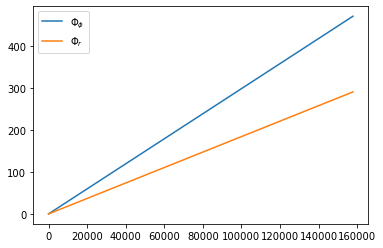

In [16]:
dt = 15.0
T = 0.005 # years

# set initial parameters
M = 1e6
mu = 1e1
p0 = 10.0
e0 = 0.7

t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0, dt=dt, T=T, upsample=True, fix_t=True)

plt.plot(t, Phi_phi, label=r'$\Phi_\phi$')
plt.plot(t, Phi_r, label=r'$\Phi_r$')
plt.legend()

In [17]:
t.max()

157785.0

### Getting dimensionless time ($t/M$)

Dimensionless time step: 20.30254435033953


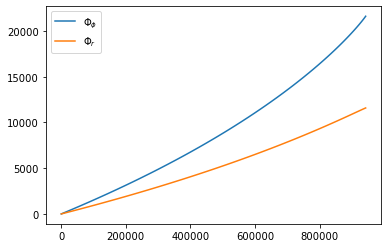

In [18]:
# set initial parameters
M = 1e5
mu = 1e1
p0 = 10.0
e0 = 0.7

t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0, in_coordinate_time=False)

plt.plot(t, Phi_phi, label=r'$\Phi_\phi$')
plt.plot(t, Phi_r, label=r'$\Phi_r$')
plt.legend()
print('Dimensionless time step:', t[1] - t[0])

### Dense Stepping

In [19]:
# initialize trajectory class
dense_traj = EMRIInspiral(func="SchwarzEccFlux")

In [20]:
dt = 15.0
T = 0.005 # years

# set initial parameters
M = 1e6
mu = 1e1
p0 = 10.0
e0 = 0.7

# make sure to increase the memory allocated for the trajectory with max_init_len
t, p, e, x, Phi_phi, Phi_theta, Phi_r = dense_traj(M, mu, 0.0, p0, e0, 1.0, dt=dt, T=T, DENSE_STEPPING=1, max_init_len=int(1e7))

In [21]:
t.shape

(10520,)

## Amplitude Module

The amplitude module generates the complex mode amplitudes for each harmonic mode requested, $A_{lmkn}(t)$ ($k=0$ for equatorial orbits). With Schwarzschild eccentric amplitudes, the user provides $p$ and $e$ as arrays and is returned the requested Teukolsky modes in a 2D array of shape (trajectory length, number of modes). 

### ROMAN amplitude generation

ROMAN uses a reduced order model representing the mode amplitude space. It then trains a neural network on this reduced model. The neural network is evaluated and the resulting matrix is transformed from the reduced basis back to the full mode space.  

In [22]:
# initialize ROMAN class
amp = RomanAmplitude(max_init_len=5000)  # max_init_len creates memory buffers

Total trajectory points: 2500


Text(0, 0.5, 'e')

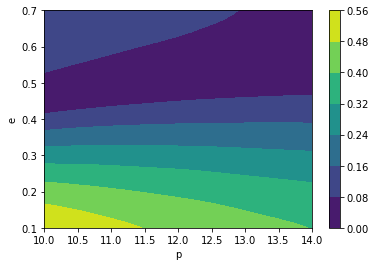

In [23]:
p = np.linspace(10.0, 14.0)
e = np.linspace(0.1, 0.7)

p_all, e_all = np.asarray([temp.ravel() for temp in np.meshgrid(p, e)])

print('Total trajectory points:', p_all.shape[0])
teuk_modes = amp(p_all, e_all)

# look at the contours of the (2,2,0) mode
cb = plt.contourf(p, e, np.abs(teuk_modes[:, amp.special_index_map[(2,2,0)]].reshape(len(p), len(e))))
plt.colorbar(cb)
plt.xlabel('p')
plt.ylabel('e')

Specific modes can be selected by providing a list of tuple of (l,m,n) values as the `specific_modes` kwarg:

Indices of interest: [ 640 1922]
True
True


Text(0, 0.5, 'e')

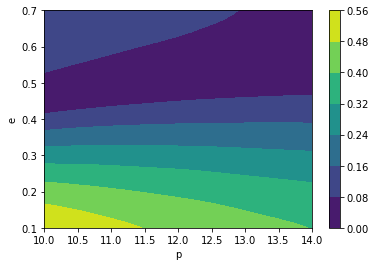

In [24]:
# (2, 2, 0) and (7, -3, 1) modes
specific_modes = [(2, 2, 0), (7, -3, 1)]

# notice this returns a dictionary with keys as the mode tuple and values as the mode values at all trajectory points
specific_teuk_modes = amp(p_all, e_all, specific_modes=specific_modes)

# we can find the index to these modes to check
inds = np.array([amp.special_index_map[lmn] for lmn in specific_modes])
print('Indices of interest:', inds)

# make sure they are the same
print(np.allclose(specific_teuk_modes[(2, 2, 0)], teuk_modes[:, inds[0]]))

# to check -m modes we need to take the conjugate
print(np.allclose(specific_teuk_modes[(7, -3, 1)], np.conj(teuk_modes[:, inds[1]])))

# look at the contours of the (220)mode
cb = plt.contourf(p, e, np.abs(specific_teuk_modes[(2, 2, 0)].reshape(len(p), len(e))))
plt.colorbar(cb)
plt.xlabel('p')
plt.ylabel('e')

### Interpolate modes with bicubic spline

For this amplitude generator, amplitudes are interpolated in 2D ($p$ and $e$) using bicubic splines. They are then evaluated for the desired modes. This is used to produce our slow waveform. This will also not scale well with dimensionality. **Note**: Specific modes can be selected in the same way as above.

In [25]:
# initialize class
amp2 = Interp2DAmplitude() 

Total trajectory points: 2500


Text(0, 0.5, 'e')

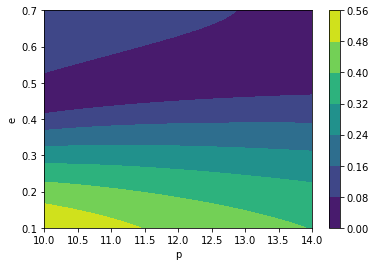

In [26]:
p = np.linspace(10.0, 14.0)
e = np.linspace(0.1, 0.7)

p_all, e_all = np.asarray([temp.ravel() for temp in np.meshgrid(p, e)])

print('Total trajectory points:', p_all.shape[0])

# to get all modes we can simply do this
teuk_modes = amp2(p_all, e_all)

# look at the contours of the (220) mode
cb = plt.contourf(p, e, np.abs(teuk_modes[:, amp2.special_index_map[(2,2,0)]].reshape(len(p), len(e))))
plt.colorbar(cb)
plt.xlabel('p')
plt.ylabel('e')

## Spin-weighted spherical harmonics

In [27]:
few = FastSchwarzschildEccentricFlux()  # get mode information

ylm_gen = GetYlms(assume_positive_m=False, use_gpu=False)

ls = np.array([2, 3, 4, 5])
ms = np.array([2, 2, 3, 3])

# viewing angles
theta = np.pi/3
phi = np.pi/4

print(ylm_gen(ls, ms, theta, phi))

[ 2.17261840e-17+3.54815511e-01j -1.28533838e-17-2.09911687e-01j
  1.24292687e-16-1.24292687e-16j -2.46692086e-01+2.46692086e-01j]


If we assume positive m, it will return -m entries for all +m. The last 5 below are for -m. The final shape will be twice the initial length and will duplicate m=0 so be careful.

In [28]:
ylm_gen = GetYlms(assume_positive_m=True, use_gpu=False)

ls = np.array([2, 3, 4, 5, 2])
ms = np.array([2, 2, 3, 3, 0])

# viewing angles
theta = np.pi/3
phi = np.pi/4

ylms = ylm_gen(ls, ms, theta, phi)

for l, m, ylm in zip(ls, ms, ylms[:5]):
    print('({},{}):'.format(l, m), ylm)
    
for l, m, ylm in zip(ls, ms, ylms[5:]):
    print('({},-{}):'.format(l, m), ylm)

(2,2): (2.1726183986132194e-17+0.35481551090908514j)
(3,2): (-1.2853383784425917e-17-0.2099116870819398j)
(4,3): (1.242926870060164e-16-1.2429268700601641e-16j)
(5,3): (-0.24669208642519044+0.2466920864251905j)
(2,0): (0.2897056515173922+0j)
(2,-2): (2.4140204429035754e-18-0.039423945656564985j)
(3,-2): (-9.997076276775717e-18+0.16326464550817543j)
(4,-3): (-0.12119256904280647-0.12119256904280648j)
(5,-3): (0.2357279936951819+0.23572799369518194j)
(2,-0): (0.2897056515173922+0j)


## Mode Selection

The mode selection module is paramount to the computational efficiency of this model. Below we show how we perform this selection operation by moving from a set of amplitudes to only those that contribute. 

### Mode selection by power contribution

Modes can also be weighted by a Power Spectral Density (PSD) function from your favorite sensitivity curve. 

In [29]:
# first, lets get amplitudes for a trajectory
traj = EMRIInspiral(func="SchwarzEccFlux")

# parameters
M = 1e5
mu = 1e1
p0 = 10.0
e0 = 0.7
theta = np.pi/3.
phi = np.pi/2.

t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0)

# get amplitudes along trajectory
amp = RomanAmplitude()

teuk_modes = amp(p, e)

# get ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

# select modes

mode_selector = ModeSelector(amp.m0mask, use_gpu=False)

eps = 1e-5  # tolerance on mode contribution to total power

modeinds = [amp.l_arr, amp.m_arr, amp.n_arr]
(teuk_modes_in, ylms_in, ls, ms, ns) = mode_selector(teuk_modes, ylms, modeinds, eps=eps)

print("We reduced the mode content from {} modes to {} modes.".format(teuk_modes.shape[1], teuk_modes_in.shape[1]))

We reduced the mode content from 3843 modes to 874 modes.


### Mode selection by noise-weighted power contribution

In [30]:
# produce sensitivity function

noise = np.genfromtxt("files/LPA.txt", names=True)
f, PSD = (
    np.asarray(noise["f"], dtype=np.float64),
    np.asarray(noise["ASD"], dtype=np.float64) ** 2,
)

sens_fn = CubicSplineInterpolant(f, PSD, use_gpu=False)

# select modes with noise weighting

# provide sensitivity function kwarg
mode_selector_noise_weighted = ModeSelector(amp.m0mask, sensitivity_fn=sens_fn, use_gpu=False)

eps = 1e-5  # tolerance on mode contribution to total power

# Schwarzschild
a = 0.0
Y = np.zeros_like(p)  # equatorial / cos iota
fund_freq_args = (M, a, p , e, Y)

modeinds = [amp.l_arr, amp.m_arr, amp.n_arr]
(teuk_modes_in, ylms_in, ls, ms, ns) = mode_selector_noise_weighted(teuk_modes, ylms, modeinds,
                                                                    fund_freq_args=fund_freq_args, eps=eps)

print("We reduced the mode content from {} modes to {} modes when using noise-weighting.".format(teuk_modes.shape[1], teuk_modes_in.shape[1]))

We reduced the mode content from 3843 modes to 783 modes when using noise-weighting.


/Users/michaelkatz/anaconda3/envs/few_env/lib/python3.7/site-packages/few-1.3.7-py3.7-macosx-10.9-x86_64.egg/few/summation/interpolatedmodesum.py:198: UserWarning: New t array outside bounds of input t array. These points are filled with edge values.
  "New t array outside bounds of input t array. These points are filled with edge values."


### Compare the two waves with and without noise-weighting

mismatch: 8.45838752716599e-06
base modes: 249
noise-weighted modes: 447


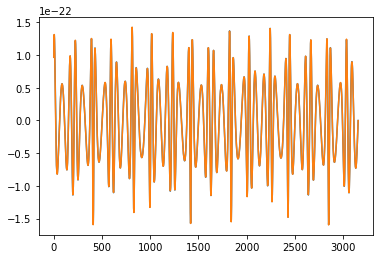

In [31]:
mode_selector_kwargs = {}

noise_weighted_mode_selector_kwargs = dict(sensitivity_fn=sens_fn)

few_base = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

few_noise_weighted = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    mode_selector_kwargs=noise_weighted_mode_selector_kwargs,
    use_gpu=use_gpu,
)

M = 1e6
mu = 1e1
p0 = 12.0
e0 = 0.3
theta = np.pi/3.
phi = np.pi/4.
dist = 1.0
dt = 10.0
T = 0.001

wave_base = few_base(M, mu, p0, e0, theta, phi, dist, dt=dt, T=0.001)
wave_weighted = few_noise_weighted(M, mu, p0, e0, theta, phi, dist, dt=dt, T=T)

plt.plot(wave_base.real)
plt.plot(wave_weighted.real)

print('mismatch:', get_mismatch(wave_base, wave_weighted))
print('base modes:', few_base.num_modes_kept)
print('noise-weighted modes:', few_noise_weighted.num_modes_kept)

### Specific mode selection

The user can also select a specific set of modes to use in the waveform.

mismatch with full wave: 0.04836198716639961


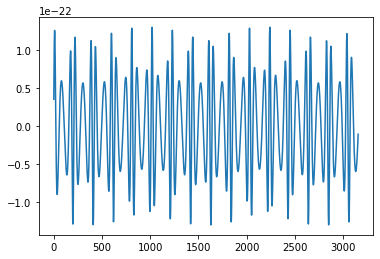

In [32]:
# l = 2, m = 2 wave
specific_modes = [(2, 2, n) for n in range(-30, 31)]

wave_22 = few_base(M, mu, p0, e0, theta, phi, dist=dist, dt=dt, T=0.001, mode_selection=specific_modes)

plt.plot(wave_22.real)

print('mismatch with full wave:', get_mismatch(wave_22, wave_base))

### Turn off ($-m$)

By default, symmetry is used to generate $-m$ modes. To turn this off and only use modes with ($m$), provide `False` to the `include_minus_m` kwarg. This only affects the waveform when `mode_selection` is a list of specific modes. 

mismatch with 22 wave with + and - m: 0.9986497050904085
mismatch with 22 original wave with adding + and - m 0.0


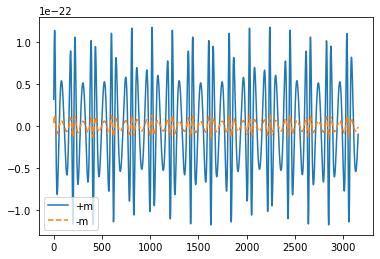

In [33]:
%matplotlib inline
# l = 2, m = 2 wave without m = -2
specific_modes = [(2, 2, n) for n in range(-30, 31)]

specific_modes_minus_m = [(2, -2, n) for n in range(-30, 31)]

wave_22_pos_m = few_base(M, mu, p0, e0, theta, phi, 
                   dist=dist, dt=dt, T=0.001, 
                   mode_selection=specific_modes, include_minus_m=False)

wave_22_minus_m = few_base(M, mu, p0, e0, theta, phi, 
                   dist=dist, dt=dt, T=0.001, 
                   mode_selection=specific_modes_minus_m, include_minus_m=False)

plt.plot(wave_22_pos_m.real, label='+m')
plt.plot(wave_22_minus_m.real, label='-m', ls='--')
plt.legend()
print('mismatch with 22 wave with + and - m:', get_mismatch(wave_22_minus_m, wave_22_pos_m))

print('mismatch with 22 original wave with adding + and - m', get_mismatch(wave_22, wave_22_pos_m + wave_22_minus_m))


## Parallelized Cubic Spline Interpolation

A part of the Fast EMRI waveforms package is parallelized cubic spline interpolation. This generally means fitting and evaluating many splines in parallel with the same input x array. This is available for GPUs and CPUs (OMP). The user can perform this operation entirely in Python while leveraging [CuPy](https://cupy.dev/) for GPUs. However, the evaluation will not be as efficient as when it is implemented properly in a customized kernel. The spline class ([CubicSplineInterpolant](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html?highlight=modeselector#few.summation.interpolatedmodesum.CubicSplineInterpolant)) can provide an 1D flattened array of all spline coefficients for use in a custom CUDA kernel. 

In [34]:
# let's take the amplitudes from the last step and spline those. 
# We have to arange everything in the shape (ninterps, length)
# We will split real and imaginary components

interp_in = np.zeros((teuk_modes.shape[1] * 2, teuk_modes.shape[0]))
                     
interp_in[:teuk_modes.shape[1], :] = teuk_modes.T.real
interp_in[teuk_modes.shape[1]:, :] = teuk_modes.T.imag

spline = CubicSplineInterpolant(t, interp_in)

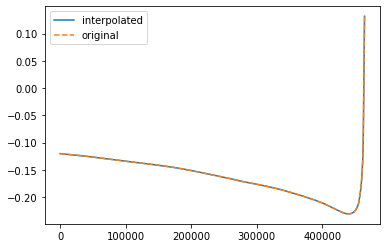

In [35]:
# get new values
t_new = np.linspace(t[0], t[-1], 1000)

# notice the new shape is (ninterps, length) just like the inital input to the spline
new_teuk_modes = spline(t_new)

# (220) mode (real part)
ind = amp.special_index_map[(2, 2, 0)]

plt.plot(t_new, new_teuk_modes[ind], label='interpolated')
plt.plot(t, teuk_modes[:, ind].real, '--', label='original')
plt.legend()

To get the array of interp coefficients for CUDA implementations, do the following. The underlying shape of the array is (4, length, ninterps). It is flattened though for entry into GPU kernel. 

In [36]:
spline.interp_array

array([ 6.23856751e-06,  3.56609646e-06, -1.26237401e-06, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

## Mode Summation

Mode summation is the bottleneck of this calculation. We handle this in two ways: interpolation for fast waveforms and direct summation for slow waveforms. They both have the same interface and produce the same product. They take Teukolsky modes and phases and combine that information to create the waveform.  

### Interpolated summation

To maximize efficiency we use the cubic spline discussed above to accelerate the computation with interpolation and parallelized summation (on the GPU or OpenMP). This class is [InterpolatedModeSum](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/sum.html?highlight=interpolated%20mode%20sum#few.summation.interpolatedmodesum.InterpolatedModeSum). 

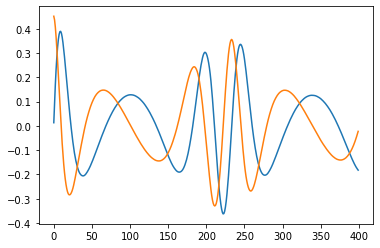

In [37]:
M = 1e6
mu = 1e1
p0 = 12.0
e0 = 0.4
theta = np.pi/5.
phi = np.pi/3.
T = 0.001
dt = 10.0
Tsec = T * YRSID_SI

traj = EMRIInspiral(func="SchwarzEccFlux")
amp = RomanAmplitude()
interpolate_mode_sum = InterpolatedModeSum()
ylm_gen = GetYlms(assume_positive_m=False)

# very simplified waveform example

# get trajectory
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(M, mu, 0.0, p0, e0, 1.0, T=T, dt=dt)

ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[
    amp.inverse_lm
]

# amplitudes
teuk_modes = amp(p, e, amp.l_arr, amp.m_arr, amp.n_arr)

# need to prepare arrays for sum with all modes due to +/- m setup
ls = amp.l_arr[: teuk_modes.shape[1]]
ms = amp.m_arr[: teuk_modes.shape[1]]
ns = amp.n_arr[: teuk_modes.shape[1]]

keep_modes = np.arange(teuk_modes.shape[1])
temp2 = keep_modes * (keep_modes < amp.num_m0) + (
    keep_modes + amp.num_m_1_up
) * (keep_modes >= amp.num_m0)

ylmkeep = np.concatenate([keep_modes, temp2])
ylms_in = ylms[ylmkeep]
teuk_modes_in = teuk_modes

# summation
waveform1 = interpolate_mode_sum(t, teuk_modes_in, ylms_in, Phi_phi, Phi_r, amp.m_arr, amp.n_arr, dt=dt, T=T)

plt.plot(waveform1.real[:400])
plt.plot(waveform1.imag[:400])

### Direct summation

For the direct mode summation, [DirectModeSum](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/sum.html?highlight=interpolated%20mode%20sum#few.summation.directmodesum.DirectModeSum), we are summing up all modes at each time step directly. So, no interpolation. However, in this example, we will use interpolation up front because we need  amplitude and phase arrays at all time steps for the direct mode sum because the direct mode sum will not fill in time steps like the interpolated mode sum.  

Mismatch: 0.0


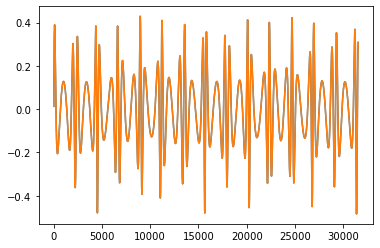

In [38]:
interp_in = np.zeros((teuk_modes.shape[1] * 2, teuk_modes.shape[0]))
                     
interp_in[:teuk_modes.shape[1], :] = teuk_modes.T.real
interp_in[teuk_modes.shape[1]:, :] = teuk_modes.T.imag

spline = CubicSplineInterpolant(t, interp_in)

# get new valu`es
t_new = np.arange(t[0], t[-1], dt)

interp_in2 = np.zeros((2, teuk_modes.shape[0]))
interp_in2[0] = Phi_phi
interp_in2[1] = Phi_r

spline2 = CubicSplineInterpolant(t, interp_in2)

Phi_phi_in, Phi_r_in = spline2(t_new)

# notice the new shape is (ninterps, length) just like the inital input to the spline
temp = spline(t_new).T


teuk_modes_in = temp[:, :teuk_modes.shape[1]] + temp[:, teuk_modes.shape[1]:]*1j

direct_mode_sum = DirectModeSum()

waveform2 = direct_mode_sum(t, teuk_modes_in, ylms_in, Phi_phi_in, Phi_r_in, amp.m_arr[:teuk_modes.shape[1]], amp.n_arr[:teuk_modes.shape[1]], dt=dt, T=T)
plt.plot(t_new, waveform1.real)
plt.plot(t_new, waveform2.real)

print('Mismatch:', get_mismatch(waveform1, waveform2))

## Utility functions

### Get options for installed ODE functions

In [39]:
from few.utils.utility import get_ode_function_options

out = get_ode_function_options()

print("Options:", list(out.keys()))

print("Info:", out)

Options: ['pn5', 'SchwarzEccFlux']
Info: {'pn5': {'type': 'func', 'files': [], 'convert_Y': True, 'num_add_args': 0, 'background': 'Kerr', 'equatorial': False, 'circular': False}, 'SchwarzEccFlux': {'type': 'class', 'files': ['FluxNewMinusPNScaled_fixed_y_order.dat'], 'num_add_args': 0, 'background': 'Schwarzschild', 'equatorial': True, 'circular': False, 'convert_Y': False}}


### Fundamental Frequencies

Get dimensionless fundamental frequencies from [Schmidt 2002](https://arxiv.org/abs/gr-qc/0202090):

In [40]:
a = 0.5

num = 10
p = np.linspace(8.0, 10.0, num)
e = np.linspace(0.2, 0.4, num)
x = np.linspace(0.3, 0.4, num)

OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a, p, e, x)

out = np.array([p, e, x, OmegaPhi, OmegaTheta, OmegaR]).T
print('p\t\te\t\tx\tOmegaPhi\tOmegaTheta\tOmegaR')
print(out)

p		e		x	OmegaPhi	OmegaTheta	OmegaR
[[ 8.          0.2         0.3         0.04344785  0.04162395  0.02349858]
 [ 8.22222222  0.22222222  0.31111111  0.0412017   0.03953685  0.02299122]
 [ 8.44444444  0.24444444  0.32222222  0.03905666  0.03753599  0.02241441]
 [ 8.66666667  0.26666667  0.33333333  0.03700405  0.03561442  0.02178189]
 [ 8.88888889  0.28888889  0.34444444  0.03503633  0.03376608  0.02110469]
 [ 9.11111111  0.31111111  0.35555556  0.0331469   0.03198567  0.02039181]
 [ 9.33333333  0.33333333  0.36666667  0.03133003  0.03026855  0.01965064]
 [ 9.55555556  0.35555556  0.37777778  0.02958068  0.02861065  0.01888732]
 [ 9.77777778  0.37777778  0.38888889  0.02789444  0.02700838  0.01810703]
 [10.          0.4         0.4         0.02626744  0.02545863  0.01731413]]


### Separatrix in Generic Kerr

Get the separatrix in generic Kerr from [Stein & Warburton 2020](https://arxiv.org/abs/1912.07609):

In [41]:
a = 0.5

num = 10
e = np.linspace(0.2, 0.4, num)
x = np.linspace(0.3, 0.4, num)

p_sep = get_separatrix(a, e, x)

out = np.array([e, x, p_sep]).T
print('e\t\tx\tseparatrix')
print(out)

e		x	separatrix
[[0.2        0.3        5.69505105]
 [0.22222222 0.31111111 5.71503552]
 [0.24444444 0.32222222 5.73483518]
 [0.26666667 0.33333333 5.75450582]
 [0.28888889 0.34444444 5.77394323]
 [0.31111111 0.35555556 5.79322634]
 [0.33333333 0.36666667 5.81236455]
 [0.35555556 0.37777778 5.83136527]
 [0.37777778 0.38888889 5.8502349 ]
 [0.4        0.4        5.86727763]]


### Get Kerr Constants of Motion $(E, L, Q)$

Get the three constants of motion $(E,L,Q)$ in generic Kerr spacetime. 

In [42]:
a = 0.5

num = 10
p = np.linspace(8.0, 10.0, num)
e = np.linspace(0.2, 0.4, num)
x = np.linspace(0.3, 0.4, num)

E, L, Q = get_kerr_geo_constants_of_motion(a, p, e, x)

out = np.array([p, e, x, E, L, Q]).T
print('p\t\te\t\tx\tE\tL\tQ')
print(out)

p		e		x	E	L	Q
[[ 8.          0.2         0.3         0.94869805  1.0488073  11.14493312]
 [ 8.22222222  0.22222222  0.31111111  0.95009671  1.09509066 11.21268793]
 [ 8.44444444  0.24444444  0.32222222  0.95151386  1.1421481  11.28086888]
 [ 8.66666667  0.26666667  0.33333333  0.95294475  1.1899692  11.34863504]
 [ 8.88888889  0.28888889  0.34444444  0.95438558  1.23854433 11.4152404 ]
 [ 9.11111111  0.31111111  0.35555556  0.95583338  1.28786454 11.48001664]
 [ 9.33333333  0.33333333  0.36666667  0.95728578  1.33792152 11.54235943]
 [ 9.55555556  0.35555556  0.37777778  0.95874089  1.38870748 11.60171749]
 [ 9.77777778  0.37777778  0.38888889  0.96019724  1.44021512 11.65758381]
 [10.          0.4         0.4         0.96165365  1.49243756 11.70948848]]


### Convert from $x_I$ to $Y$

$Y\equiv\cos{\iota}=L/\sqrt{L^2 + Q}$ is different than $x_I\equiv \cos{I}$, which is accepted for relativistic waveforms and in the generic waveform interface discussed above. $I$ is the inclination angle of the orbital plane to the to equatorial plane. 

In [43]:
a = 0.5

num = 10
p = np.linspace(8.0, 10.0, num)
e = np.linspace(0.2, 0.4, num)
x = np.linspace(0.3, 0.4, num)

Y = xI_to_Y(a, p, e, x)

out = np.array([p, e, x, Y]).T
print('To Y:\np\t\te\t\tx\tY')
print(out)

x_new = Y_to_xI(a, p, e, Y)
out = np.array([p, e, x_new, Y]).T
print('To x:\np\t\te\t\tx\tY')
print(out)

To Y:
p		e		x	Y
[[ 8.          0.2         0.3         0.29972126]
 [ 8.22222222  0.22222222  0.31111111  0.31083559]
 [ 8.44444444  0.24444444  0.32222222  0.32195073]
 [ 8.66666667  0.26666667  0.33333333  0.33306659]
 [ 8.88888889  0.28888889  0.34444444  0.3441831 ]
 [ 9.11111111  0.31111111  0.35555556  0.3553002 ]
 [ 9.33333333  0.33333333  0.36666667  0.36641781]
 [ 9.55555556  0.35555556  0.37777778  0.3775359 ]
 [ 9.77777778  0.37777778  0.38888889  0.38865439]
 [10.          0.4         0.4         0.39977325]]
To x:
p		e		x	Y
[[ 8.          0.2         0.3         0.29972126]
 [ 8.22222222  0.22222222  0.31111111  0.31083559]
 [ 8.44444444  0.24444444  0.32222222  0.32195073]
 [ 8.66666667  0.26666667  0.33333333  0.33306659]
 [ 8.88888889  0.28888889  0.34444444  0.3441831 ]
 [ 9.11111111  0.31111111  0.35555556  0.3553002 ]
 [ 9.33333333  0.33333333  0.36666667  0.36641781]
 [ 9.55555556  0.35555556  0.37777778  0.3775359 ]
 [ 9.77777778  0.37777778  0.38888889  0.38865439

### Get $\mu$ based on desired duration of waveform

If you have a desired length of waveform to analyze, this function will give you the value of $\mu$ that corresponds to the proper evolution time. 

In [44]:
traj_module = EMRIInspiral(func="SchwarzEccFlux")

# set initial parameters
M = 1e6
p0 = 11.0
e0 = 0.7

traj_args = [M, 0.0, p0, e0, 1.0]
traj_kwargs = {}
index_of_mu = 1

t_out = 1.5
# run trajectory
mu_new = get_mu_at_t(
    traj_module,
    t_out,
    traj_args,
    index_of_mu=index_of_mu,
    traj_kwargs=traj_kwargs,
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)

print('mu = {} will create a waveform that is {} years long, given the other input parameters.'.format(mu_new, t_out))

mu = 18.804088097128368 will create a waveform that is 1.5 years long, given the other input parameters.


### Get $p_0$ based on desired duration of waveform

If you have a desired length of waveform to analyze, this function will give you the value of $p_0$ that corresponds to the proper evolution time. 

In [45]:
traj_module = EMRIInspiral(func="SchwarzEccFlux")

# set initial parameters
M = 1e6
mu = 5e1
e0 = 0.7

traj_args = [M, mu, 0.0, e0, 1.0]
traj_kwargs = {}
index_of_p = 3

t_out = 1.5
# run trajectory
p_new = get_p_at_t(
    traj_module,
    t_out,
    traj_args,
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    traj_kwargs={},
    kerr_separatrix=False,
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)

print('p0 = {} will create a waveform that is {} years long, given the other input parameters.'.format(p_new, t_out))

p0 = 13.059790473435857 will create a waveform that is 1.5 years long, given the other input parameters.


### Set/get `omp_num_threads`

In [46]:
from few.utils.utility import omp_get_num_threads, omp_set_num_threads

omp_set_num_threads(3)
omp_get_num_threads()

3

### Change CUDA device

In [47]:
from few.utils.utility import cuda_set_device

## Creating  modules

In addition to using our built-in modules and waveforms, you can easily create your own module or waveform. Below is an example of creating your own trajectory module and using it in a custom waveform. If you can get a reasonably fast trajectory from your specific brand of EMRI physics, you can be generating waveforms in no time! Please see the [documentation](https://mikekatz04.github.io/FastEMRIWaveforms/) on this for more details on the constructions behind this. 

**Important Note**: If you do use this package to examine EMRI analysis problems, please contact the authors of this code (see docs) about possible collaboration and/or contribution.

### Post-Newtonian trajectory

The example will be to implement a Post-Newtonian trajectory in a Schwarzschild eccentric waveform. This will be done purely in Python. However, most of our modules have backends in C/C++/CUDA for maximum efficiency. If you have a trajectory in python and want to see if it can be ported for speed, please contact the authors.

To get started, we will import an integrator ([DOP853](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.DOP853.html#scipy.integrate.DOP853)) and a library for elliptical integrals that mirrors the mathematica format `mpmath`. You can run: 

```
pip install mpmath
```

in your conda environment to attain that library. 

We will also import necessary things from our package. This includes constants from `few.utils.constants`, as well as two base classes to be inherited by the new module. 

The first base class is [SchwarzschildEccentric](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/main.html#few.utils.baseclasses.SchwarzschildEccentric) base class that passes information specific to any Schwarzschild eccentric waveform (number of modes, (l,m,n) sets, etc.). It also has methods for general sanity checks in these limits for input parameters, trajectories, and other things. You can see the documentation for more detail on its properties. 

The other base class is [TrajectoryBase](file:///Users/michaelkatz/Research/FastEMRIWaveforms/docs/html/user/traj.html#few.utils.baseclasses.TrajectoryBase). This houses both information for trajectory modules, as well as the interface that should be common to all trajectory modules (i.e. [__call__](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/traj.html?highlight=trajectorybase#few.utils.baseclasses.TrajectoryBase.__call__) function). It allows for flexible parameter calling interfaces, but ensures the strict interface will be the same for all trajectory modules. Trajectory modules must implement the method [get_inspial](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/traj.html?highlight=trajectorybase#few.utils.baseclasses.TrajectoryBase.get_inspiral). The common interface uses this to generate the specific trajectory. 

This is a common theme amongst module and waveform creation. The user will take one parent abstract base class related to the waveform limits, domain of validity, and its waveform properties, and one parent abstract based class for the module type (like trajectory or summation). 

In [48]:
# we need to import an integrator and elliptic integrals
from mpmath import *
from scipy.integrate import DOP853

# base classes
from few.utils.baseclasses import TrajectoryBase
from few.utils.baseclasses import SchwarzschildEccentric

# settings for elliptic integrals
mp.dps = 25
mp.pretty = True

# constants from our package
from few.utils.constants import MTSUN_SI, YRSID_SI, Pi

# for common interface with C/mathematica
def Power(x, n):
    return x**n

def Sqrt(x):
    return np.sqrt(x)

# this is class object just to hold epsilon as it steps
# this class is instantiated and then run like the derivative function in the integrator (ex. dydt)
class PN:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def __call__(self, t, y):

        # mass ratio
        epsilon = self.epsilon

        # extract the four evolving parameters
        p, e, Phi_phi, Phi_r = y
        
        # guard against bad integration steps
        if e >= 1.0 or e < 1e-2 or p < 6.0 or (p - 6 - 2* e) < 0.1:
            return [0.0, 0.0]
        

        # perform elliptic calculations
        EllipE = ellipe(4*e/(p-6.0+2*e))
        EllipK = ellipk(4*e/(p-6.0+2*e))
        EllipPi1 = ellippi(16*e/(12.0 + 8*e - 4*e*e - 8*p + p*p), 4*e/(p-6.0+2*e))
        EllipPi2 = ellippi(2*e*(p-4)/((1.0+e)*(p-6.0+2*e)), 4*e/(p-6.0+2*e))

        # Azimuthal frequency
        Omega_phi = (2*Power(p,1.5))/(Sqrt(-4*Power(e,2) + Power(-2 + p,2))*(8 + ((-2*EllipPi2*(6 + 2*e - p)*(3 + Power(e,2) - p)*Power(p,2))/((-1 + e)*Power(1 + e,2)) - (EllipE*(-4 + p)*Power(p,2)*(-6 + 2*e + p))/(-1 + Power(e,2)) +
              (EllipK*Power(p,2)*(28 + 4*Power(e,2) - 12*p + Power(p,2)))/(-1 + Power(e,2)) + (4*(-4 + p)*p*(2*(1 + e)*EllipK + EllipPi2*(-6 - 2*e + p)))/(1 + e) + 2*Power(-4 + p,2)*(EllipK*(-4 + p) + (EllipPi1*p*(-6 - 2*e + p))/(2 + 2*e - p)))/
            (EllipK*Power(-4 + p,2))))

        # Post-Newtonian calculations
        yPN = pow(Omega_phi,2./3.)

        EdotPN = (96 + 292*Power(e,2) + 37*Power(e,4))/(15.*Power(1 - Power(e,2),3.5)) * pow(yPN, 5)
        LdotPN = (4*(8 + 7*Power(e,2)))/(5.*Power(-1 + Power(e,2),2)) * pow(yPN, 7./2.)

        # flux
        Edot = -epsilon*(EdotPN)
        Ldot = -epsilon*(LdotPN)

        # time derivatives
        pdot = (-2*(Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*(3 + Power(e,2) - p)*Power(p,1.5) + Ldot*Power(-4 + p,2)*Sqrt(-3 - Power(e,2) + p)))/(4*Power(e,2) - Power(-6 + p,2))

        edot = -((Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*Power(p,1.5)*
        (18 + 2*Power(e,4) - 3*Power(e,2)*(-4 + p) - 9*p + Power(p,2)) +
        (-1 + Power(e,2))*Ldot*Sqrt(-3 - Power(e,2) + p)*(12 + 4*Power(e,2) - 8*p + Power(p,2)))/
        (e*(4*Power(e,2) - Power(-6 + p,2))*p))
        
        Phi_phi_dot = Omega_phi;

        Phi_r_dot = (p*Sqrt((-6 + 2*e + p)/(-4*Power(e,2) + Power(-2 + p,2)))*Pi)/(8*EllipK + ((-2*EllipPi2*(6 + 2*e - p)*(3 + Power(e,2) - p)*Power(p,2))/((-1 + e)*Power(1 + e,2)) - (EllipE*(-4 + p)*Power(p,2)*(-6 + 2*e + p))/(-1 + Power(e,2)) +
        (EllipK*Power(p,2)*(28 + 4*Power(e,2) - 12*p + Power(p,2)))/(-1 + Power(e,2)) + (4*(-4 + p)*p*(2*(1 + e)*EllipK + EllipPi2*(-6 - 2*e + p)))/(1 + e) + 2*Power(-4 + p,2)*(EllipK*(-4 + p) + (EllipPi1*p*(-6 - 2*e + p))/(2 + 2*e - p)))/Power(-4 + p,2))

        dydt = [pdot, edot, Phi_phi_dot, Phi_r_dot]

        return dydt

    
# this is the actual class that implements a PN trajectory. It uses the PN class in the integrator.
class PnTrajectory(TrajectoryBase):
    
    # for common interface with *args and **kwargs
    def __init__(self, *args, **kwargs):
        pass
    
    # required by the trajectory base class
    def get_inspiral(self, M, mu, a, p0, e0, x0, T=1.0, **kwargs):

        # set up quantities and integrator
        y0 = [p0, e0, 0.0, 0.0]

        T = T * YRSID_SI / (M * MTSUN_SI)
        
        Msec = M * MTSUN_SI

        epsilon = mu/M
        integrator = DOP853(PN(epsilon), 0.0, y0, T)

        t_out, p_out, e_out = [], [], []
        Phi_phi_out, Phi_r_out = [], []
        t_out.append(0.0)
        p_out.append(p0)
        e_out.append(e0)
        Phi_phi_out.append(0.0)
        Phi_r_out.append(0.0)

        # run the integrator down to T or separatrix
        run = True
        while integrator.t < T and run:
            integrator.step()
            p, e, Phi_phi, Phi_r = integrator.y
            t_out.append(integrator.t * Msec)
            p_out.append(p)
            e_out.append(e)
            Phi_phi_out.append(Phi_phi)
            Phi_r_out.append(Phi_r)

            if (p - 6 -2*e) < 0.1:
                run = False

        # read out data. It must return length 6 tuple
        t = np.asarray(t_out)
        p = np.asarray(p_out)
        e = np.asarray(e_out)
        Phi_phi = np.asarray(Phi_phi_out)
        Phi_r = np.asarray(Phi_r_out)
        
        # need to add polar info 
        Phi_theta = Phi_phi.copy()  # by construction
        x = np.ones_like(Phi_theta)

        return (t, p, e, x, Phi_phi, Phi_theta, Phi_r)

### Test your trajectory

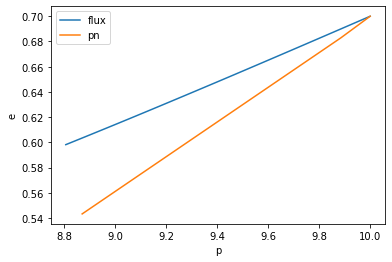

In [49]:
M = 1e6
mu = 1e1
p0 = 10.0
e0 = 0.7
T = 1.0

traj = PnTrajectory()

test = traj(M, mu, 0.0, p0, e0, 1.0, T=T, dt=10.0)

traj2 = EMRIInspiral(func="SchwarzEccFlux")

flux = traj2(M, mu, 0.0, p0, e0, 1.0, T=T, dt=10.0)

p = test[1]
e = test[2] 

import matplotlib.pyplot as plt
plt.plot(flux[1], flux[2], label='flux')
plt.plot(p, e, label='pn')
plt.ylabel('e')
plt.xlabel('p')

plt.legend()
plt.savefig('trajectory_pn_vs_flux.pdf', dpi=200)

Text(0, 0.5, 'p')

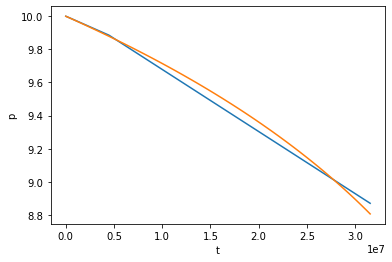

In [50]:
plt.plot(test[0], test[1])
plt.plot(flux[0], flux[1])
plt.xlabel('t')
plt.ylabel('p')

Text(0, 0.5, 'e')

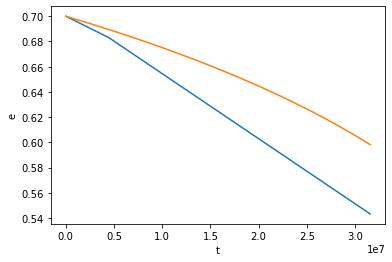

In [51]:
plt.plot(test[0], test[2])
plt.plot(flux[0], flux[2])
plt.xlabel('t')
plt.ylabel('e')

### Implement ODE in C/C++

If you want to implement a set of ODE equations in C/C++, you can add your function to `src/ode_base.cc`. When you run `python setup install`, the installer will build a full file of ODEs and take care of all of the backend aspects to the integration. **You only have to implement the ODE**. You identify the ODE functions with `__deriv__` decorator. `#define` is then used to give extra necessary information on the function. Options are:

* `#define {waveform function name}_num_add_args {number of added args}`: Number of additional arguments beyond the required arguments. 
* `#define {waveform function name}_spinless`: Indicated Schwarzschild background. 
* `#define {waveform function name}_circular`: No eccentricity. 
* `#define {waveform function name}_equatorial`: Constrained to equatorial plane.
* `#define {waveform function name}_Y`: Indicates the function is integrated in $Y$ rather than $x_I$. 
* `#define {waveform function name}_file{file number} {file name}`: File names required for proper use of function. 
* `#define {waveform function name}_citation{citation number} {citation name}`: Citations for the function. `citation name` should be the name of the variable the citation is assigned to in `few.utils.citations`.

The `__deriv__` function must be of the form:
````
void {functionname}(double* pdot, double* edot, double* Ydot,
                  double* Omega_phi, double* Omega_theta, double* Omega_r,
                  double epsilon, double a, double p, double e, double Y, double* additional_args)
````
`double*` args, except `additional_args`, represent pointers to doubles representing the output derivative values.
`double` args are input values.
`additional_args` is a pointer to a double array that holds any extra arguments to be included.

#### Analytic functions that do not need storage

If the ODE is purely analytic, a function will work. Here is an example with the 5PN trajectory:

````
#define pn5_Y
#define pn5_citation1 pn5_citation
__deriv__
void pn5(double* pdot, double* edot, double* Ydot,
                  double Omega_phi, double Omega_theta, double Omega_r,
                  double epsilon, double a, double p, double e, double Y, double* additional_args)
{
    // evaluate ODEs

	int Nv = 10;
    int ne = 10;
    *pdot = epsilon * dpdt8H_5PNe10 (a, p, e, Y, Nv, ne);

    // needs adjustment for validity
    Nv = 10;
    ne = 8;
	*edot = epsilon * dedt8H_5PNe10 (a, p, e, Y, Nv, ne);

    Nv = 7;
    ne = 10;
    *Ydot = -epsilon * dYdt8H_5PNe10 (a, p, e, Y, Nv, ne);

    // convert to proper inclination input to fundamental frequencies
    double xI = Y_to_xI(a, p, e, Y);
    KerrGeoCoordinateFrequencies(Omega_phi, Omega_theta, Omega_r, a, p, e, xI);

}
````

`#define pn5_y` indicates the function integrates in $Y$ rather than $x_I$.  


#### Functions that require storage

If your function requires the storage of files or interpolants, you can also build your ODE as a class. In this case, 
it must have a constructor, destructor, and method called `deriv_func` with the ODEs.

Here is the implementation for the flux driven trajectory:

````


// Class to carry gsl interpolants for the inspiral data
// also executes inspiral calculations
SchwarzEccFlux::SchwarzEccFlux(std::string few_dir)
{
    interps = new interp_params;

    // prepare the data
    // python will download the data if
    // the user does not have it in the correct place
    load_and_interpolate_flux_data(interps, few_dir);
	//load_and_interpolate_amp_vec_norm_data(&amp_vec_norm_interp, few_dir);
}

#define SchwarzEccFlux_num_add_args 0
#define SchwarzEccFlux_spinless
#define SchwarzEccFlux_equatorial
#define SchwarzEccFlux_file1 FluxNewMinusPNScaled_fixed_y_order.dat
__deriv__
void SchwarzEccFlux::deriv_func(double* pdot, double* edot, double* xdot,
                  double Omega_phi, double Omega_theta, double Omega_r,
                  double epsilon, double a, double p, double e, double x, double* additional_args)
{
    if ((6.0 + 2. * e) > p)
    {
        *pdot = 0.0;
        *edot = 0.0;
        *xdot = 0.0;

        return;
    }
    double y1 = log((p -2.*e - 2.1));

    // evaluate ODEs, starting with PN contribution, then interpolating over remaining flux contribution

    SchwarzschildGeoCoordinateFrequencies(Omega_phi, Omega_r, p, e);

	double yPN = pow((Omega_phi),2./3.);

	double EdotPN = (96 + 292*Power(e,2) + 37*Power(e,4))/(15.*Power(1 - Power(e,2),3.5)) * pow(yPN, 5);
	double LdotPN = (4*(8 + 7*Power(e,2)))/(5.*Power(-1 + Power(e,2),2)) * pow(yPN, 7./2.);

	double Edot = -epsilon*(interps->Edot->eval(y1, e)*pow(yPN,6.) + EdotPN);

	double Ldot = -epsilon*(interps->Ldot->eval(y1, e)*pow(yPN,9./2.) + LdotPN);

	*pdot = (-2*(Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*(3 + Power(e,2) - p)*Power(p,1.5) + Ldot*Power(-4 + p,2)*Sqrt(-3 - Power(e,2) + p)))/(4*Power(e,2) - Power(-6 + p,2));

    // handle e = 0.0
	if (e > 0.)
    {
        *edot = -((Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*Power(p,1.5)*
            	  (18 + 2*Power(e,4) - 3*Power(e,2)*(-4 + p) - 9*p + Power(p,2)) +
            	 (-1 + Power(e,2))*Ldot*Sqrt(-3 - Power(e,2) + p)*(12 + 4*Power(e,2) - 8*p + Power(p,2)))/
            	(e*(4*Power(e,2) - Power(-6 + p,2))*p));
    }
    else
    {
        *edot = 0.0;
    }

    *xdot = 0.0;
}


// When interfacing with cython, it helps to have  dealloc function to explicitly call
// rather than the deconstructor
SchwarzEccFlux::~SchwarzEccFlux()
{

    delete interps->Edot;
    delete interps->Ldot;
    delete interps;


}

````

### Make a waveform model

Now we will create a waveform with our new trajectory model. To do this, we will start with [SchwarzschildEccentricWaveformBase](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/main.html#few.waveform.SchwarzschildEccentricWaveformBase). This base class has already inherited from [SchwarzschildEccentric](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/main.html#few.utils.baseclasses.SchwarzschildEccentric). It creates the common interface for all waveform modules (and how they interface with there constituent modules). A requirement when creating a module is to have properties describing the GPU capability of the waveform, as well as whether or not it allows for batching the waveform creation (after trajectory).  

In [52]:
class FastSchwarzschildEccentricPn(SchwarzschildEccentricWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        amplitude_kwargs={},
        sum_kwargs={},
        Ylm_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):

        SchwarzschildEccentricWaveformBase.__init__(
            self,
            PnTrajectory,
            RomanAmplitude,
            InterpolatedModeSum,
            inspiral_kwargs=inspiral_kwargs,
            amplitude_kwargs=amplitude_kwargs,
            sum_kwargs=sum_kwargs,
            Ylm_kwargs=Ylm_kwargs,
            use_gpu=use_gpu,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False

### Test your waveform

It will have the same interface as the other waveforms. 

In [53]:
test = FastSchwarzschildEccentricPn()

M = 1e6
mu = 1e1
p0 = 12.0
e0 = 0.4
theta = np.pi/3.
phi = np.pi/4.
dist = 1.0

T = 0.2
dt = 15.0

wave1 = test(M, mu, p0, e0, theta, phi, dist=dist, dt=dt, T=T)

wave2 = few(M, mu, p0, e0, theta, phi, dist=dist, dt=dt, T=T)


mismatch: 0.932708770516795


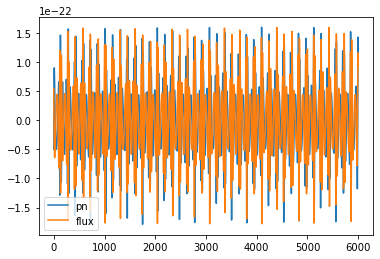

In [54]:
# end of waveform is where we can see the difference
plt.plot(wave1.real[-6000:], label='pn')
plt.plot(wave2.real[-6000:], label='flux')
plt.legend()
print('mismatch:', get_mismatch(wave1, wave2))
plt.savefig('pn_vs_flux.pdf', dpi=200)

## Augmented Analytic Kludge with 5PN trajectory

We have now implemented a new version of the Augmented Analytic Kludge with 5PN trajectories.

Waveforms are generated based on the Augmented Analytic Kludge given in the [EMRI Kludge Suite](https://github.com/alvincjk/EMRI_Kludge_Suite/). However, here the trajectory is vastly improved by employing the 5PN fluxes for generic Kerr orbits from [Fujita & Shibata (2020)](https://arxiv.org/abs/2008.13554). 

The 5PN trajectory produces orbital and phase trajectories. The trajectory is calculated until the orbit reaches within 0.2 of the separatrix, determined from [Stein and Warburton (2020)](https://arxiv.org/abs/1912.07609/). The
fundamental frequencies along the trajectory at each point are then calculated from the orbital parameters and the spin value given by [Schmidt (2002)](https://arxiv.org/abs/gr-qc/0202090>).

These frequencies along the trajectory are then used to map to the frequency basis of the [Analytic Kludge](https://arxiv.org/abs/gr-qc/0310125). This mapping takes the form of time evolving large mass and spin parameters, as
well as the use of phases and frequencies in $\alpha, \Phi, \gamma$:

\begin{align}
\Phi &= \Phi_\phi, \\
\gamma &= \Phi_\phi + \Phi_\theta, \\
\alpha &= \Phi_\phi + \Phi_\theta + \Phi_r. \\
\end{align}


The frequencies in that basis are found by taking the time derivatives
of each equation above.

**Please note:** the 5PN trajectory and AAK waveform take the parameter $Y\equiv\cos{\iota}=L/\sqrt{L^2 + Q}$ rather than $x_I$ as is accepted for relativistic waveforms and in the generic waveform interface discussed above. The generic waveform interface directly converts $x_I$ to $Y$. 

This class has GPU capabilities and works from the sparse trajectory methodoligy with cubic spine interpolation of the smoothly varying waveform quantities. This waveform does not have the freedom in terms of user-chosen quantitites that
`few.waveform.SchwarzschildEccentricWaveformBase` contains. This is mainly due to the specific waveform constructions particular to the AAK/AK.


In [55]:
use_gpu = False

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
inspiral_kwargs = {
    "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
}

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

wave_generator = Pn5AAKWaveform(inspiral_kwargs=inspiral_kwargs, sum_kwargs=sum_kwargs, use_gpu=False)

# set initial parameters
M = 1e6
mu = 1e1
a = 0.2
p0 = 14.0
e0 = 0.6
iota0 = 0.1
Y0 = np.cos(iota0)
Phi_phi0 = 0.2
Phi_theta0 = 1.2
Phi_r0 = 0.8


qS = 0.2
phiS = 0.2
qK = 0.8
phiK = 0.8
dist = 1.0
mich = False
dt = 15.0
T = 2.0

waveform = wave_generator(M, mu, a, p0, e0, Y0, qS, phiS, qK, phiK, dist, 
                          Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=T)

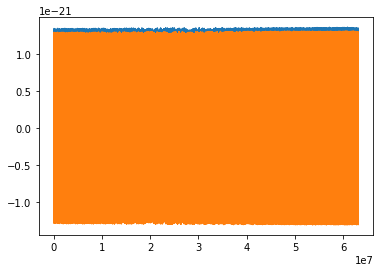

In [56]:
t = np.arange(len(waveform)) * dt
plt.plot(t, waveform.real)
plt.plot(t, waveform.imag)

We can also assume a long-wavelength LISA response by setting `mich=True`. Please note this is not Time-delay interferometry (TDI).

In [57]:
waveform_lw = wave_generator(M, mu, a, p0, e0, Y0, qS, phiS, qK, phiK, dist, mich=True, dt=dt, T=T)

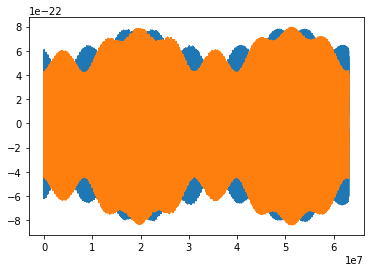

In [58]:
t = np.arange(len(waveform_lw)) * dt
plt.plot(t, waveform_lw.real)
plt.plot(t, waveform_lw.imag)

### 5PN Trajectory

This new waveform includes 5PN trajectories from [Fujita & Shibata 2020](https://arxiv.org/abs/2008.13554).

In [59]:
# initialize trajectory class
traj = EMRIInspiral(func="pn5")

In [60]:
# set initial parameters
M = 1e5
mu = 1e1
a = 0.5
p0 = 14.0
e0 = 0.7
iota0 = 0.1
Y0 = np.cos(iota0)
T = 2.0
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0


# run trajectory
t, p, e, Y, Phi_phi, Phi_r, Phi_theta = traj(M, mu, a, p0, e0, Y0, 
                                             Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, T=T)
print(len(p), p.min())

156 4.529679786509501


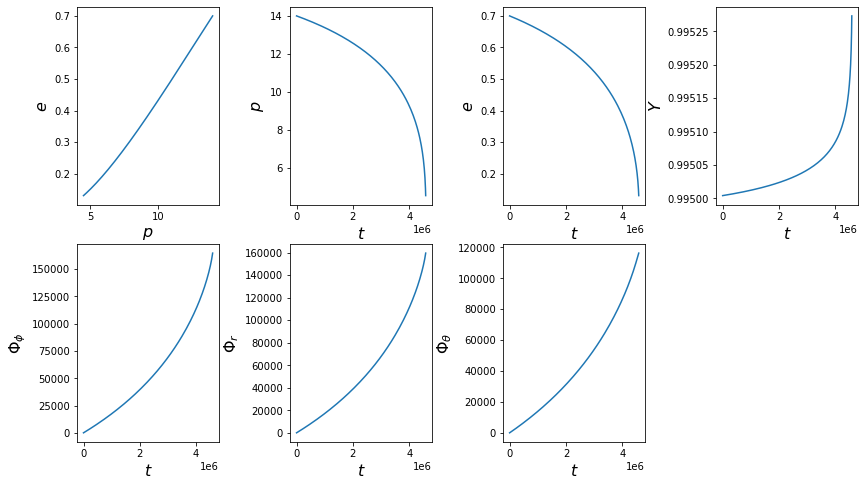

In [61]:
fig, axes = plt.subplots(2, 4)
plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$Y$', r'$\Phi_\phi$', r'$\Phi_r$', r'$\Phi_\theta$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e, p, e, Y, Phi_phi, Phi_r, Phi_theta]
xs = [p, t, t, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
    
axes[-1].set_visible(False)

With the PN trajectory, we need to be careful at smaller $p$, larger $a$, and larger $e$. This trajectory can exihibt pathological behavior near these extremes. Therefore, we provide the option to truncate the trajectory at the Schwarzschild ($a=0$) separatrix, $6 + 2e$. To do this, you provide the keyword `enforce_schwarz_sep=True` to the initialization of the class.

In [62]:
# initialize trajectory class
traj = EMRIInspiral(func="pn5", enforce_schwarz_sep=True)

In [63]:
# set initial parameters
M = 1e5
mu = 1e1
a = 0.5
p0 = 14.0
e0 = 0.7
iota0 = 0.1
Y0 = np.cos(iota0)
T = 2.0
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0


# run trajectory
t, p, e, Y, Phi_phi, Phi_r, Phi_theta = traj(M, mu, a, p0, e0, Y0, 
                                             Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, T=T)
print(len(p), p.min())

120 6.549942327110178


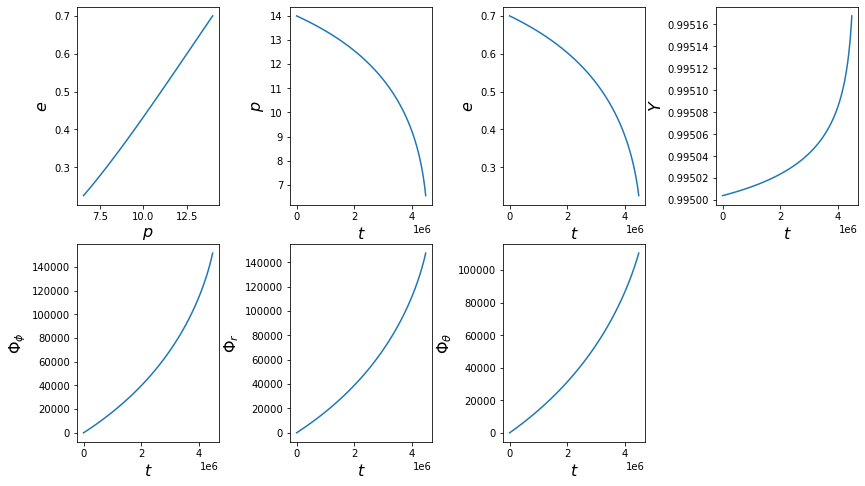

In [64]:
fig, axes = plt.subplots(2, 4)
plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$Y$', r'$\Phi_\phi$', r'$\Phi_r$', r'$\Phi_\theta$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e, p, e, Y, Phi_phi, Phi_r, Phi_theta]
xs = [p, t, t, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
    
axes[-1].set_visible(False)

### Building an AAK waveform from a given trajectory (in this case the 5PN trajectory)

In [65]:
from few.utils.baseclasses import Pn5AAK, ParallelModuleBase

class NewPn5AAKWaveform(AAKWaveformBase, Pn5AAK, ParallelModuleBase):
    def __init__(
        self, inspiral_kwargs={}, sum_kwargs={}, use_gpu=False, num_threads=None
    ):

        inspiral_kwargs["func"] = "pn5"

        AAKWaveformBase.__init__(
            self,
            EMRIInspiral,  # trajectory class
            AAKSummation,
            inspiral_kwargs=inspiral_kwargs,
            sum_kwargs=sum_kwargs,
            use_gpu=use_gpu,
            num_threads=num_threads,
        )

        

In [66]:
# set initial parameters
M = 1e6
mu = 1e1
a = 0.2
p0 = 14.0
e0 = 0.6
iota0 = 0.1
Y0 = np.cos(iota0)
Phi_phi0 = 0.2
Phi_theta0 = 1.2
Phi_r0 = 0.8


qS = 0.2
phiS = 0.2
qK = 0.8
phiK = 0.8
dist = 1.0
mich = False
dt = 15.0
T = 2.0

wave_generator = NewPn5AAKWaveform()
AAK_out = wave_generator(M, mu, a, p0, e0, Y0, qS, phiS, qK, phiK, dist, 
                          Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=T)

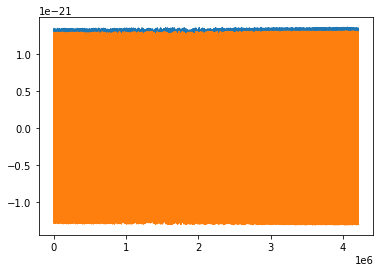

In [67]:
plt.plot(AAK_out.real)
plt.plot(AAK_out.imag)

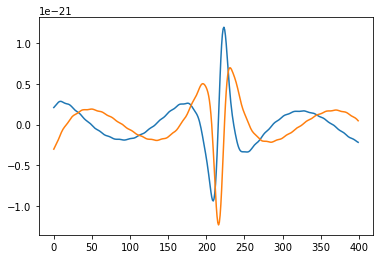

In [68]:
plt.plot(AAK_out.real[:400])
plt.plot(AAK_out.imag[:400])

### Generating the new AAK with the generic waveform generator

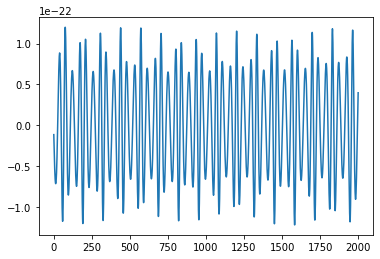

In [69]:
gen_wave = GenerateEMRIWaveform("Pn5AAKWaveform")

# parameters
T = 0.01  # years
dt = 15.0  # seconds
M = 1e6
a = 0.1 
mu = 1e1
p0 = 12.0
e0 = 0.2
x0 = 0.6  # notice this is x_I, not Y. The AAK waveform can convert to Y. 
qK = 0.2  # polar spin angle
phiK = 0.2  # azimuthal viewing angle
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal viewing angle
dist = 1.0  # distance
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0

h = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

plt.plot(h.real[:2000])

## Citing waveforms and modules

If you use any work from this package please cite our papers [arxiv.org/2104.04582](https://arxiv.org/abs/2104.04582) and [arxiv.org/2008.06071](https://arxiv.org/abs/2008.06071). Additionally please cite any additional work for each module used by calling the `citation` attribute on the module class:

### Fast Schwarzschild Eccentric Waveforms

In [70]:
wave = FastSchwarzschildEccentricFlux()
print(wave.citation)


@article{Katz:2021yft,
    author = "Katz, Michael L. and Chua, Alvin J. K. and Speri, Lorenzo and Warburton, Niels and Hughes, Scott A.",
    title = "{FastEMRIWaveforms: New tools for millihertz gravitational-wave data analysis}",
    eprint = "2104.04582",
    archivePrefix = "arXiv",
    primaryClass = "gr-qc",
    month = "4",
    year = "2021"
}

@article{Chua:2020stf,
    author = "Chua, Alvin J. K. and Katz, Michael L. and Warburton, Niels and Hughes, Scott A.",
    title = "{Rapid generation of fully relativistic extreme-mass-ratio-inspiral waveform templates for LISA data analysis}",
    eprint = "2008.06071",
    archivePrefix = "arXiv",
    primaryClass = "gr-qc",
    doi = "10.1103/PhysRevLett.126.051102",
    journal = "Phys. Rev. Lett.",
    volume = "126",
    number = "5",
    pages = "051102",
    year = "2021"
}

@software{michael_l_katz_2020_4005001,
  author       = {Michael L. Katz and
                  Alvin J. K. Chua and
                  Niels Warburton and
 

### New and Improved AAK with 5PN Trajectory

In [71]:
wave_aak = Pn5AAKWaveform()
print(wave_aak.citation)


@article{Katz:2021yft,
    author = "Katz, Michael L. and Chua, Alvin J. K. and Speri, Lorenzo and Warburton, Niels and Hughes, Scott A.",
    title = "{FastEMRIWaveforms: New tools for millihertz gravitational-wave data analysis}",
    eprint = "2104.04582",
    archivePrefix = "arXiv",
    primaryClass = "gr-qc",
    month = "4",
    year = "2021"
}

@article{Chua:2020stf,
    author = "Chua, Alvin J. K. and Katz, Michael L. and Warburton, Niels and Hughes, Scott A.",
    title = "{Rapid generation of fully relativistic extreme-mass-ratio-inspiral waveform templates for LISA data analysis}",
    eprint = "2008.06071",
    archivePrefix = "arXiv",
    primaryClass = "gr-qc",
    doi = "10.1103/PhysRevLett.126.051102",
    journal = "Phys. Rev. Lett.",
    volume = "126",
    number = "5",
    pages = "051102",
    year = "2021"
}

@software{michael_l_katz_2020_4005001,
  author       = {Michael L. Katz and
                  Alvin J. K. Chua and
                  Niels Warburton and
 